<a href="https://colab.research.google.com/github/TivoGatto/VAEs/blob/master/DRAW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# LIBRARIES
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Lambda, LSTM, Activation, Add, Reshape
import keras.backend as K

Using TensorFlow backend.


In [ ]:
# PARAMETERS
input_dim = 784
intermediate_dim = 256
latent_dim = 30

T = 10
N = 5

epochs = 10
batch_size = 200
epsilon_std = 1.0

In [ ]:
# FUNCTIONS

def draw_loss(x_true, x_pred):
	x_pred = sigm(x_pred) 

	xent_loss = keras.losses.binary_crossentropy(x_true, x_pred)
	reg_loss = 0

	for t in range(1, T+1):
		reg_loss += 0.5 * K.sum(K.square(z_mean[t]) + K.exp(z_log_var[t]) - z_log_var[t], 1) - 0.5

	return K.mean(xent_loss + reg_loss)

def Regularizer(x_true, x_pred):
	reg_loss = 0

	for t in range(1, T+1):
		reg_loss += 0.5 * K.sum(K.square(z_mean[t]) + K.exp(z_log_var[t]) - z_log_var[t], axis=-1) - 0.5

	return K.mean(reg_loss)
 
def L2(x_true, x_pred):
	return keras.losses.binary_crossentropy(x_true, x_pred)

def Conc(args):
	return K.concatenate(args, axis=-1)

def Sampling(args):
	z_mean, z_log_var = args
	epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)

	return z_mean + K.exp(0.5 * z_log_var) * epsilon 

def Read(args):
	x, x_hat, h_dec = args

	return conc([x, x_hat])

def Write(args):
	h_dec = args

	return Dense(input_dim)(h_dec)

def Add_time(args):
	return K.expand_dims(args, 1)

In [ ]:
# MODEL

sigm = Activation("sigmoid")
conc = Lambda(Conc)
sampling = Lambda(Sampling)
add_time = Lambda(Add_time)


read = Lambda(Read)
write = Lambda(Write)

encoder = LSTM(intermediate_dim, stateful=True)
decoder = LSTM(intermediate_dim, stateful=True)

x_hat = [0] * (T + 1)
r     = [0] * (T + 1)
z     = [0] * (T + 1)

z_mean = [0] * (T + 1)
z_log_var = [0] * (T + 1)

h_enc = [0] * (T + 1)
h_dec = [0] * (T + 1)
C     = [0] * (T + 1)

x = Input(shape=(input_dim, ))
h_enc_init = Input(tensor=K.zeros(shape=(batch_size,  intermediate_dim)))
h_dec_init = Input(tensor=K.zeros(shape=(batch_size,  intermediate_dim)))
C_0 = Input(tensor=K.zeros(shape=(batch_size, input_dim)))

h_enc[0] = Dense(intermediate_dim)(h_enc_init)
h_dec[0] = Dense(intermediate_dim)(h_dec_init)
C[0]     = Dense(input_dim)(C_0)

for t in range(1, T+1):
    x_hat[t] = keras.layers.Subtract()([x, sigm(C[t-1])])
    r[t]     = read([x, x_hat[t], h_dec[t-1]])

    h_enc[t] = encoder(add_time(conc([h_enc[t-1], r[t], h_dec[t-1]])))

    z_mean[t] = Dense(latent_dim)(h_enc[t])
    z_log_var[t] = Dense(latent_dim)(h_enc[t])

    z[t] = sampling([z_mean[t], z_log_var[t]])

    h_dec[t] = decoder(add_time(conc([h_dec[t-1], z[t]])))

    C[t] = Add()([C[t-1], write(h_dec[t])])

model = Model([x, C_0, h_dec_init, h_enc_init], C[T])

optmizers = keras.optimizers.RMSprop()
model.compile(optimizer=optmizers, loss=draw_loss, metrics=[L2, Regularizer])

print(model.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (200, 784)           0                                            
__________________________________________________________________________________________________
dense_218 (Dense)               (200, 784)           615440      input_24[0][0]                   
__________________________________________________________________________________________________
input_23 (InputLayer)           (200, 256)           0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 784)          0                                            
____________________________________________________________________________________________

In [ ]:
# MODEL

#sigm = Activation("sigmoid")
#conc = Lambda(Conc)
#sampling = Lambda(Sampling)

#read = Lambda(Read)
#write = Lambda(Write)

#encoder = LSTM(latent_dim)
#decoder = LSTM(input_dim)

#x = Input(shape=(input_dim, ))
#h_enc_init = Input(tensor=K.zeros(shape=(batch_size, latent_dim, )))
#h_dec_init = Input(tensor=K.zeros(shape=(batch_size, latent_dim, )))
#C_0 = Input(tensor=K.zeros(shape=(batch_size, input_dim, )))

#h_enc = Dense(latent_dim)(h_enc_init)
#h_dec = Dense(input_dim)(h_dec_init)
#C_t   = Dense(input_dim)(C_0)

#kl = []
#for t in range(T):
#    x_hat = keras.layers.Subtract()([x, C_t])
#    r_t = read([x, x_hat])

#    info = conc([r_t, h_dec])
#    info = keras.layers.Reshape((-1, K.int_shape(h_dec)[1] + K.int_shape(r_t)[1]))(info)
#    h_enc = encoder(info)

#    z_mean = Dense(latent_dim)(h_enc)
#    z_log_var = Dense(latent_dim)(h_enc)

#    z = sampling([z_mean, z_log_var])

#    z_reshaped = keras.layers.Reshape((1, latent_dim))(z)
#    h_dec = decoder(z_reshaped)

#    C_t = keras.layers.Add()([C_t, write(h_dec)])
#    kl.append(0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - 1 - z_log_var, axis=-1))


#model = Model([x, C_0, h_dec_init, h_enc_init], C_t)
#model.compile(optimizer='adam', loss=draw_loss, metrics=[L2, Regularizer])

In [ ]:
# IMPORT DATA
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = np.reshape(x_train, (-1, input_dim))/255
x_test = np.reshape(x_test, (-1, input_dim))/255

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [ ]:
model.fit(x_train, x_train, batch_size=batch_size, epochs=epochs)

Epoch 1/10
26000/60000 [============>.................] - ETA: 10s - loss: 145.4684 - L2: 1.6952 - Regularizer: 145.0605

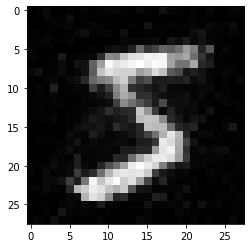

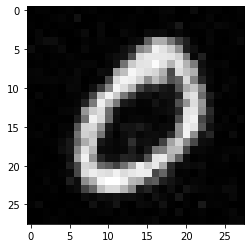

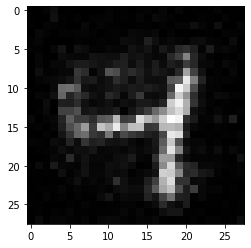

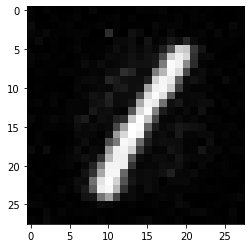

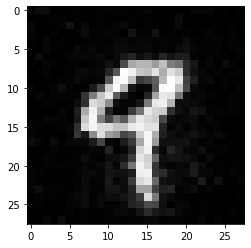

In [ ]:
x_recon = model.predict(x_train, batch_size=batch_size)
x_recon = 1 / (1 + np.exp(-x_recon))


for i in range(5):
    X_recon = x_recon[i]
    X_recon = np.reshape(X_recon, (28, 28))

    plt.imshow(X_recon, cmap='gray')
    plt.show()

In [ ]:
n = 10

C_0 = Input(tensor=K.zeros(shape=(n, input_dim)))
Z_t = Input(shape=(T, latent_dim))

C_t = Dense(input_dim)(C_0)
h_dec = decoder(Z_t)
C_t = keras.layers.Add()([C_t, write(h_dec)])

generator = Model([Z_t, C_0], C_t)

z_t = np.random.normal(size=(n, T, latent_dim))
x_gen = generator.predict(z_t)

x_gen = np.reshape(x_gen, (n, 28, 28))

for i in x_gen:
    plt.imshow(i, cmap='gray')
    plt.show()

ValueError: ignored